# Multi-Layer Neural Nets

In this exercise you will implement two-layer and three-layer networks from scratch using a  modular approach. For each layer you will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, theta):
  """ Receive inputs x and weights theta """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, theta, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, theta, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dtheta = # Derivative of loss with respect to w
  
  return dx, dtheta
```

After implementing a bunch of layers this way, you will be able to easily combine them to build classifiers with different architectures.
  

In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Load the CIFAR10 Dataset

In [2]:
import pickle
import numpy as np
import os
from matplotlib.pyplot import imread

def load_CIFAR_batch(filename,encoding='latin1'):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y


def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f,encoding = 'latin1')
        xs.append(X)
        ys.append(Y)    
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data (CHANGE THE PATH BELOW)
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    
    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
      'X_train': X_train, 'y_train': y_train,
      'X_val': X_val, 'y_val': y_val,
      'X_test': X_test, 'y_test': y_test,
    }

In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print ('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Affine layer: foward

Complete the following code cell to implement the forward propagation for each layer, later you will call this function for each layer when you do forward propagation.

In [4]:
def affine_forward(x, theta, theta0):
    """
      Computes the forward pass for an affine (fully-connected) layer.

      The input x has shape (m, d_1, ..., d_k) and contains a minibatch of m
      examples, where each example x[i] has shape (d_1, ..., d_k). We will
      reshape each input into a vector of dimension d = d_1 * ... * d_k, and
      then transform it to an output vector of dimension h.

      Inputs:
      - x: A numpy array containing input data, of shape (m, d_1, ..., d_k)
      - theta: A numpy array of weights, of shape (d, h)
      - theta0: A numpy array of biases, of shape (h,)

      Returns a tuple of:
      - out: output, of shape (m, h)
      - cache: (x, theta, theta0)
    """
    out = None
    #############################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You     #
    # will need to reshape the input into rows.                                 #
    #############################################################################
    # 2 lines of code expected
    m = x.shape[0]
    x_flattened = x.reshape(m, -1)
    
    # affine transformation
    out = np.dot(x_flattened, theta) + theta0

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = (x, theta, theta0)
    return out, cache

# Affine layer: foward test

In [5]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
theta = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape),output_dim)
theta0 = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, theta, theta0)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print ('Testing affine_forward function:')
print ('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking. The function will be called by each layer when you do backward propagation.

In [10]:
def affine_backward(dout, cache):
    """
      Computes the backward pass for an affine layer.

      Inputs:
      - dout: Upstream derivative, of shape (m, h)
      - cache: Tuple of:
        - x: Input data, of shape (m, d_1, ... d_k)
        - theta: Weights, of shape (d,h)
        - theta0: biases, of shape (h,)

      Returns a tuple of:
      - dx: Gradient with respect to x, of shape (m, d1, ..., d_k)
      - dtheta: Gradient with respect to theta, of shape (d, h)
      - dtheta0: Gradient with respect to theta0, of shape (h,)
    """
    x, theta, theta0 = cache
    dx, dtheta, dtheta0 = None, None, None
    #############################################################################
    # TODO: Implement the affine backward pass.                                 #
    #############################################################################
    # Hint: do not forget to reshape x into (m,d) form
    # 4-5 lines of code expected
    # reshape
    m = x.shape[0]
    x_reshaped = x.reshape(m, -1)
    
    # loss Gradient wrt weights
    dtheta = np.dot(x_reshaped.T, dout)

    # loss Gradient wrt biases
    dtheta0 = np.sum(dout, axis=0)

    # loss Gradient wrt input
    dx = np.dot(dout, theta.T)
    dx = dx.reshape(*x.shape)
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return dx, dtheta, dtheta0



# Affine layer: backward test

In [11]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
theta = np.random.randn(6, 5)
theta0 = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, theta, theta0)[0], x, dout)
dtheta_num = eval_numerical_gradient_array(lambda theta: affine_forward(x, theta, theta0)[0], theta, dout)
dtheta0_num = eval_numerical_gradient_array(lambda theta0: affine_forward(x, theta, theta0)[0], theta0, dout)

_, cache = affine_forward(x, theta, theta0)
dx, dtheta, dtheta0 = affine_backward(dout, cache)


# The error should be less than 1e-09
print ('Testing affine_backward function:')
print ('dx error: {}'.format(rel_error(dx_num, dx)) )
print ('dtheta error: {}'.format(rel_error(dtheta_num, dtheta)))
print ('dtheta0 error: {}'.format(rel_error(dtheta0_num, dtheta0)))

Testing affine_backward function:
dx error: 2.3784281133622786e-10
dtheta error: 3.0257511953984576e-10
dtheta0 error: 1.8709303715674298e-11


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

The relu function is:

f(x) = max(x, 0)

In [12]:
def relu_forward(x):
    """
      Computes the forward pass for a layer of rectified linear units (ReLUs).

      Input:
      - x: Inputs, of any shape

      Returns a tuple of:
      - out: Output, of the same shape as x
      - cache: x
    """
    out = None
    #############################################################################
    # TODO: Implement the ReLU forward pass.                                    #
    #############################################################################
    # 1 line of code expected
    out = np.maximum(x, 0)
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = x
    return out, cache


# ReLU layer: forward test

In [14]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)


out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print ('Testing relu_forward function:')
print ('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [15]:

def relu_backward(dout, cache):
    """
      Computes the backward pass for a layer of rectified linear units (ReLUs).

      Input:
      - dout: Upstream derivatives, of any shape
      - cache: Input x, of same shape as dout

      Returns:
      - dx: Gradient with respect to x
    """
    dx, x = None, cache
    #############################################################################
    # TODO: Implement the ReLU backward pass.                                   #
    #############################################################################
    # 1 line of code expected. Hint: use np.where
    # newx: m,d
    dx = dout * (x > 0)
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return dx

# ReLU layer: backward test

In [16]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)


# The error should be around 1e-12
print ('Testing relu_backward function:')
print ('dx error: {} '.format(rel_error(dx_num, dx)))

Testing relu_backward function:
dx error: 3.2756151576825172e-12 


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the following code cells.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [17]:
from layers import *

def affine_relu_forward(x, theta, theta0):
    """
      Convenience layer that perorms an affine transform followed by a ReLU

      Inputs:
      - x: Input to the affine layer
      - theta, theta0: Weights for the affine layer

      Returns a tuple of:
      - out: Output from the ReLU
      - cache: Object to give to the backward pass
    """
    a, fc_cache = affine_forward(x, theta, theta0)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache


def affine_relu_backward(dout, cache):
    """
      Backward pass for the affine-relu convenience layer
    """
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dtheta, dtheta0 = affine_backward(da, fc_cache)
    return dx, dtheta, dtheta0


In [18]:
x = np.random.randn(2, 3, 4)
theta = np.random.randn(12, 10)
theta0 = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, theta, theta0)
dx, dtheta, dtheta0 = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, theta, theta0)[0], x, dout)
dtheta_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, theta, theta0)[0], theta, dout)
dtheta0_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, theta, theta0)[0], theta0, dout)

print ('Testing affine_relu_backward:')
print ('dx error: ', rel_error(dx_num, dx))
print ('dtheta error: ', rel_error(dtheta_num, dtheta))
print ('dtheta0 error: ', rel_error(dtheta0_num, dtheta0))

Testing affine_relu_backward:
dx error:  6.884303572222475e-11
dtheta error:  1.843961666495661e-10
dtheta0 error:  3.275550436783338e-12


# Loss layers: Softmax and SVM


In [19]:
def softmax_loss(x, y):
    """
      Computes the loss and gradient for softmax classification.

      Inputs:
      - x: Input data, of shape (m, C) where x[i, j] is the score for the jth class
        for the ith input.
      - y: Vector of labels, of shape (m,) where y[i] is the label for x[i] and
        0 <= y[i] < C

      Returns a tuple of:
      - loss: Scalar giving the loss
      - dx: Gradient of the loss with respect to x
    """
    probs = np.exp(x - np.max(x, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    m = x.shape[0]
    loss = -np.sum(np.log(probs[np.arange(m), y])) / m
    dx = probs.copy()
    dx[np.arange(m), y] -= 1
    dx /= m
    return loss, dx

In [20]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print ('\nTesting softmax_loss:')
print ('loss: ', loss)
print ('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.3026046146070227
dx error:  8.097128394237981e-09


# Two-layer network

Complete the implementation of the `TwoLayerNet` class in the following code cell. This class will serve as a model for the other networks you will implement in this assignment.  Read through it to make sure you understand the API. After implementing it you can run the cell below to test your implementation.

In [21]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of d, a hidden dimension of h, and perform classification over C classes.
  
    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """
  
    def __init__(self, input_dim=3*32*32, hidden_dim=100, num_classes=10,
               weight_scale=1e-3, reg=0.0):
        """
        Initialize a new network.
        
        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - dropout: Scalar between 0 and 1 giving dropout strength.
        - weight_scale: Scalar giving the standard deviation for random
            initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg
    
        ############################################################################
        # TODO: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a zero-mean Gaussian with stdev equal to      #
        # weight_scale, and biases should be initialized to zero. All weights and  #
        # biases should be stored in the dictionary self.params, with first layer  #
        # weights and biases using the keys 'theta1' and 'theta1_0' and second     #
        # layer weights and biases using the keys 'theta2' and 'theta2_0.          #
        # theta1 has shape (input_dim,hidden-dim), theta1_0 shape is (hidden_dim,) #
        # theta2 shape is (hidden_dim,num_classes), theta2_0 shape is (num_classes,)#
        ############################################################################
        # 4 lines of code expected
        self.params['theta1'] = weight_scale * np.random.randn(input_dim, hidden_dim)
        self.params['theta1_0'] = np.zeros(hidden_dim)
        self.params['theta2'] = weight_scale * np.random.randn(hidden_dim, num_classes)
        self.params['theta2_0'] = np.zeros(num_classes)
        
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################


    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.
        
        Inputs:
        - X: Array of input data of shape (m, d_1, ..., d_k)
        - y: Array of labels, of shape (m,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (m, C) giving classification scores, where
            scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
        names to gradients of the loss with respect to those parameters.
        """  
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the two-layer net, computing the    #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################
        # Hint: unpack the weight parameters from self.params
        # then calculate output of two layer network using functions defined before
        # 3 lines of code expected
        hidden_layer, cache_hidden_layer = affine_forward(X, self.params['theta1'], self.params['theta1_0'])
        hidden_layer_relu, cache_hidden_layer_relu = relu_forward(hidden_layer)
        scores, cache_scores = affine_forward(hidden_layer_relu, self.params['theta2'], self.params['theta2_0'])
        
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores
    
        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the two-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k]. Don't forget to add L2 regularization!                   #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        
        # 4-8 lines of code expected
        # loss
        loss, dscores = softmax_loss(scores, y)
        loss += 0.5 * self.reg * (np.sum(self.params['theta1'] ** 2) + np.sum(self.params['theta2'] ** 2))

        # backpropagation
        dhidden_layer_relu, grads['theta2'], grads['theta2_0'] = affine_backward(dscores, cache_scores)
        dhidden_layer = relu_backward(dhidden_layer_relu, cache_hidden_layer_relu)
        _, grads['theta1'], grads['theta1_0'] = affine_backward(dhidden_layer, cache_hidden_layer)

        # regularization gradients
        grads['theta1'] += self.reg * self.params['theta1']
        grads['theta2'] += self.reg * self.params['theta2']
        
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        return loss, grads

In [22]:
m, d, h, C = 3, 5, 50, 7
X = np.random.randn(m, d)
y = np.random.randint(C, size=m)

std = 1e-2
model = TwoLayerNet(input_dim=d, hidden_dim=h, num_classes=C, weight_scale=std)

print ('Testing initialization ... ')
theta1_std = abs(model.params['theta1'].std() - std)
theta1_0 = model.params['theta1_0']
theta2_std = abs(model.params['theta2'].std() - std)
theta2_0 = model.params['theta2_0']
assert theta1_std < std / 10, 'First layer weights do not seem right'
assert np.all(theta1_0 == 0), 'First layer biases do not seem right'
assert theta2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(theta2_0 == 0), 'Second layer biases do not seem right'

print ('Testing test-time forward pass ... ')
model.params['theta1'] = np.linspace(-0.7, 0.3, num=d*h).reshape(d, h)
model.params['theta1_0'] = np.linspace(-0.1, 0.9, num=h)
model.params['theta2'] = np.linspace(-0.3, 0.4, num=h*C).reshape(h, C)
model.params['theta2_0'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=m*d).reshape(d, m).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print ('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
    print ('Running numeric gradient check with reg = ', reg)
    model.reg = reg
    loss, grads = model.loss(X, y)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
theta1 relative error: 1.52e-08
theta1_0 relative error: 8.37e-09
theta2 relative error: 3.21e-10
theta2_0 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
theta1 relative error: 2.53e-07
theta1_0 relative error: 1.56e-08
theta2 relative error: 2.85e-08
theta2_0 relative error: 7.76e-10


# Three-Layer Neural Network



In [23]:
class ThreeLayerNet(object):
    """
    A Three-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of d, a hidden dimension of h, and perform classification over C classes.
  
    The architecure should be affine - relu - affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """
  
    def __init__(self, input_dim=3*32*32, hidden_dim_1=100, hidden_dim_2 = 100, num_classes=10,
               weight_scale=1e-2, reg=0.0):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim_1: An integer giving the size of the first hidden layer
        - hidden_dim_2: An integer giving the size of the second hidden layer
        - num_classes: An integer giving the number of classes to classify
        - dropout: Scalar between 0 and 1 giving dropout strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg
    
        #################################################################################
        # TODO: Initialize the weights and biases of the three-layer net. Weights       #
        # should be initialized from a zero-mean Gaussian with stdev equal to           #
        # weight_scale, and biases should be initialized to zero. All weights and       #
        # biases should be stored in the dictionary self.params, with first layer       #
        # weights and biases using the keys 'theta1' and 'theta1_0' and second          #
        # layer weights and biases using the keys 'theta2' and 'theta2_0. the third     #
        # layer weights and biases using the keys 'theta3' and 'theta3_0'.              #
        # theta1 has shape (input_dim,hidden-dim-1), theta1_0 shape is (hidden-dim-1,)  #
        # theta2 shape is (hidden_dim-1,hidden_dim-2), theta2_0 shape is (hidden_dim-2,)#
        # theta3 shape is (hidden_dim-2, num_classes), theta3_0 shape is (num_classes)  # 
        #################################################################################
        # 6 lines of code expected
        self.params['theta1'] = weight_scale * np.random.randn(input_dim, hidden_dim_1)
        self.params['theta1_0'] = np.zeros(hidden_dim_1)
        self.params['theta2'] = weight_scale * np.random.randn(hidden_dim_1, hidden_dim_2)
        self.params['theta2_0'] = np.zeros(hidden_dim_2)
        self.params['theta3'] = weight_scale * np.random.randn(hidden_dim_2, num_classes)
        self.params['theta3_0'] = np.zeros(num_classes)
        
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################


    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (m, d_1, ..., d_k)
        - y: Array of labels, of shape (m,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (m, C) giving classification scores, where
              scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
        names to gradients of the loss with respect to those parameters.
        """  
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the three-layer net, computing the  #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################
        # Hint: unpack the weight parameters from self.params
        # then calculate output of two layer network using functions defined before
        # 3 lines of code expected
        hidden_layer1, cache_hidden_layer1 = affine_forward(X, self.params['theta1'], self.params['theta1_0'])
        hidden_layer1_relu, cache_hidden_layer1_relu = relu_forward(hidden_layer1)
        hidden_layer2, cache_hidden_layer2 = affine_forward(hidden_layer1_relu, self.params['theta2'], self.params['theta2_0'])
        hidden_layer2_relu, cache_hidden_layer2_relu = relu_forward(hidden_layer2)
        scores, cache_scores = affine_forward(hidden_layer2_relu, self.params['theta3'], self.params['theta3_0'])
        
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores
    
        loss, grads = 0, {}
        ##############################################################################
        # TODO: Implement the backward pass for the three-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data   #
        # loss using softmax, and make sure that grads[k] holds the gradients for    #
        # self.params[k]. Don't forget to add L2 regularization!                     #
        #                                                                            #
        # NOTE: To ensure that your implementation matches ours and you pass the     #
        # automated tests, make sure that your L2 regularization includes a factor   #
        # of 0.5 to simplify the expression for the gradient.                        #
        ##############################################################################

        # 8-11 lines of code expected
        loss, dout3 = softmax_loss(scores, y)
        
        # loss and gradient for softmax
        loss += 0.5 * self.reg * (np.sum(self.params['theta1'] ** 2) + np.sum(self.params['theta2'] ** 2) + np.sum(self.params['theta3'] ** 2))

        # backpropagation
        dhidden_layer2_relu, grads['theta3'], grads['theta3_0'] = affine_backward(dout3, cache_scores)
        dhidden_layer2 = relu_backward(dhidden_layer2_relu, cache_hidden_layer2_relu)
        dhidden_layer1_relu, grads['theta2'], grads['theta2_0'] = affine_backward(dhidden_layer2, cache_hidden_layer2)
        dhidden_layer1 = relu_backward(dhidden_layer1_relu, cache_hidden_layer1_relu)
        dx, grads['theta1'], grads['theta1_0'] = affine_backward(dhidden_layer1, cache_hidden_layer1)

        # regularization gradients
        grads['theta1'] += self.reg * self.params['theta1']
        grads['theta2'] += self.reg * self.params['theta2']
        grads['theta3'] += self.reg * self.params['theta3']

    
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        return loss, grads

In [24]:
m, d, h1, h2, C = 3, 5, 50, 30, 7
X = np.random.randn(m, d)
y = np.random.randint(C, size=m)

std = 1e-2
model = ThreeLayerNet(input_dim=d, hidden_dim_1=h1, hidden_dim_2=h2, num_classes=C, weight_scale=std)

print ('Testing initialization ... ')
theta1_std = abs(model.params['theta1'].std() - std)
theta1_0 = model.params['theta1_0']
theta2_std = abs(model.params['theta2'].std() - std)
theta2_0 = model.params['theta2_0']
theta3_std = abs(model.params['theta3'].std() - std)
theta3_0 = model.params['theta3_0']
assert theta1_std < std / 10, 'First layer weights do not seem right'
assert np.all(theta1_0 == 0), 'First layer biases do not seem right'
assert theta2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(theta2_0 == 0), 'Second layer biases do not seem right'
assert theta3_std < std / 10, 'Second layer weights do not seem right'
assert np.all(theta3_0 == 0), 'Second layer biases do not seem right'


print ('Testing test-time forward pass ... ')
model.params['theta1'] = np.linspace(-0.7, 0.3, num=d*h1).reshape(d, h1)
model.params['theta1_0'] = np.linspace(-0.1, 0.9, num=h1)
model.params['theta2'] = np.linspace(-0.3, 0.4, num=h1*h2).reshape(h1, h2)
model.params['theta2_0'] = np.linspace(-0.9, 0.1, num=h2)
model.params['theta3'] = np.linspace(-0.3, 0.4, num=h2*C).reshape(h2, C)
model.params['theta3_0'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=m*d).reshape(d, m).T
scores = model.loss(X)
correct_scores = np.asarray([
 [ 24.7529953, 26.30758862, 27.86218194, 29.41677527, 30.97136859, 32.52596191, 34.08055524],
 [ 24.2416125, 25.82700689, 27.41240129, 28.99779568, 30.58319008, 32.16858448, 33.75397887],
 [ 23.7302297, 25.34642517, 26.96262063, 28.5788161, 30.19501157, 31.81120704, 33.42740251]]
)
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print ('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 6.56064352723
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 59.1928674811
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
    print ('Running numeric gradient check with reg = ', reg)
    model.reg = reg
    loss, grads = model.loss(X, y)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
theta1 relative error: 3.37e-07
theta1_0 relative error: 3.27e-07
theta2 relative error: 2.40e-09
theta2_0 relative error: 6.01e-09
theta3 relative error: 3.98e-09
theta3_0 relative error: 1.23e-08
Running numeric gradient check with reg =  0.7
theta1 relative error: 3.05e-07
theta1_0 relative error: 7.54e-07
theta2 relative error: 4.15e-06
theta2_0 relative error: 1.17e-08
theta3 relative error: 9.78e-07
theta3_0 relative error: 1.23e-08


# Solver

Open the file `solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [27]:
model = TwoLayerNet()
sgd_solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# Get the CIFAR-10 data broken up into train, validation and test sets
data = get_CIFAR10_data()

# config solver
sgd_solver = Solver(model, data,
                    update_rule='sgd',
                    optim_config={
                        'learning_rate': 1e-3,  # Experiment with this
                    },
                    lr_decay=0.95,
                    num_epochs=10,  # Experiment with this
                    batch_size=100, # Experiment with this
                    print_every=100)

# train model
sgd_solver.train()


##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.299190
(Epoch 0 / 10) train acc: 0.126000; val_acc: 0.125000
(Iteration 101 / 4900) loss: 1.751393
(Iteration 201 / 4900) loss: 1.757832
(Iteration 301 / 4900) loss: 1.623652
(Iteration 401 / 4900) loss: 1.621494
(Epoch 1 / 10) train acc: 0.460000; val_acc: 0.456000
(Iteration 501 / 4900) loss: 1.587237
(Iteration 601 / 4900) loss: 1.385960
(Iteration 701 / 4900) loss: 1.326371
(Iteration 801 / 4900) loss: 1.595906
(Iteration 901 / 4900) loss: 1.577633
(Epoch 2 / 10) train acc: 0.478000; val_acc: 0.466000
(Iteration 1001 / 4900) loss: 1.652966
(Iteration 1101 / 4900) loss: 1.396819
(Iteration 1201 / 4900) loss: 1.476349
(Iteration 1301 / 4900) loss: 1.353142
(Iteration 1401 / 4900) loss: 1.382591
(Epoch 3 / 10) train acc: 0.498000; val_acc: 0.470000
(Iteration 1501 / 4900) loss: 1.365065
(Iteration 1601 / 4900) loss: 1.406858
(Iteration 1701 / 4900) loss: 1.041392
(Iteration 1801 / 4900) loss: 1.156308
(Iteration 1901 / 4900) loss: 1.429552
(Epoch 4 / 10) t

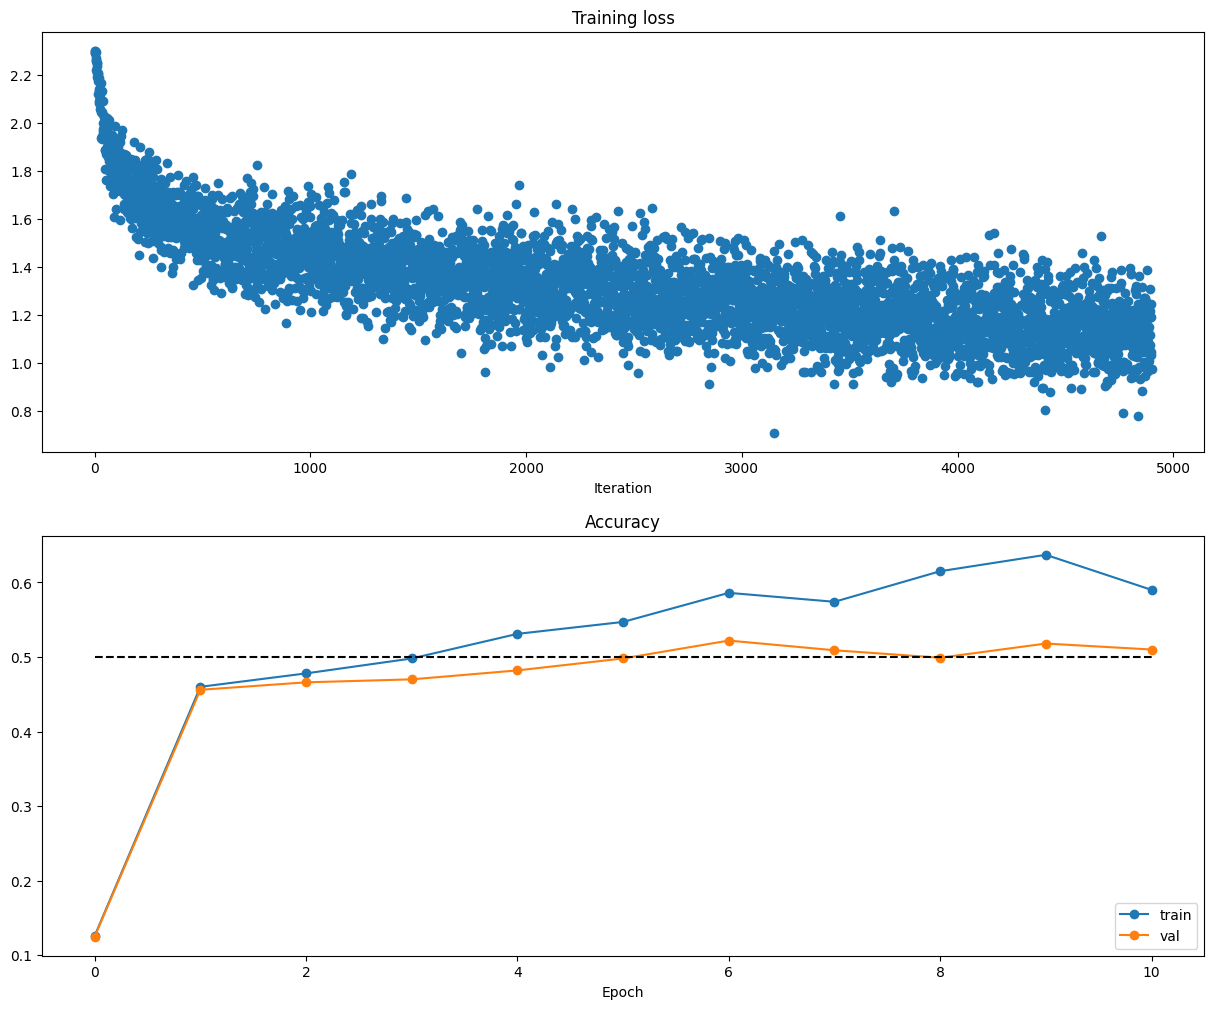

In [28]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(sgd_solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(sgd_solver.train_acc_history, '-o', label='train')
plt.plot(sgd_solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(sgd_solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Three-Layer Neural Network

use a `Solver` instance to train a `Three-Layer Neural` and plot the training loss as well as the accuracy cruve.

In [29]:
model = ThreeLayerNet()
sgd_solver = None


data_dict = get_CIFAR10_data()

data = {
    'X_train': data_dict['X_train'],
    'y_train': data_dict['y_train'],
    'X_val': data_dict['X_val'],
    'y_val': data_dict['y_val'],
  }

sgd_solver = Solver(model, data,
                  update_rule='sgd',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  lr_decay=0.95,
                  num_epochs=20, batch_size=100,
                  print_every=100)
sgd_solver.train()


(Iteration 1 / 9800) loss: 2.307213
(Epoch 0 / 20) train acc: 0.119000; val_acc: 0.096000
(Iteration 101 / 9800) loss: 2.149776
(Iteration 201 / 9800) loss: 1.904931
(Iteration 301 / 9800) loss: 1.785509
(Iteration 401 / 9800) loss: 1.909288
(Epoch 1 / 20) train acc: 0.366000; val_acc: 0.350000
(Iteration 501 / 9800) loss: 1.605948
(Iteration 601 / 9800) loss: 1.629686
(Iteration 701 / 9800) loss: 1.835141
(Iteration 801 / 9800) loss: 1.535353
(Iteration 901 / 9800) loss: 1.417469
(Epoch 2 / 20) train acc: 0.397000; val_acc: 0.407000
(Iteration 1001 / 9800) loss: 1.603457
(Iteration 1101 / 9800) loss: 1.611996
(Iteration 1201 / 9800) loss: 1.504780
(Iteration 1301 / 9800) loss: 1.777954
(Iteration 1401 / 9800) loss: 1.662056
(Epoch 3 / 20) train acc: 0.409000; val_acc: 0.425000
(Iteration 1501 / 9800) loss: 1.459295
(Iteration 1601 / 9800) loss: 1.452559
(Iteration 1701 / 9800) loss: 1.528047
(Iteration 1801 / 9800) loss: 1.586997
(Iteration 1901 / 9800) loss: 1.361122
(Epoch 4 / 20) t

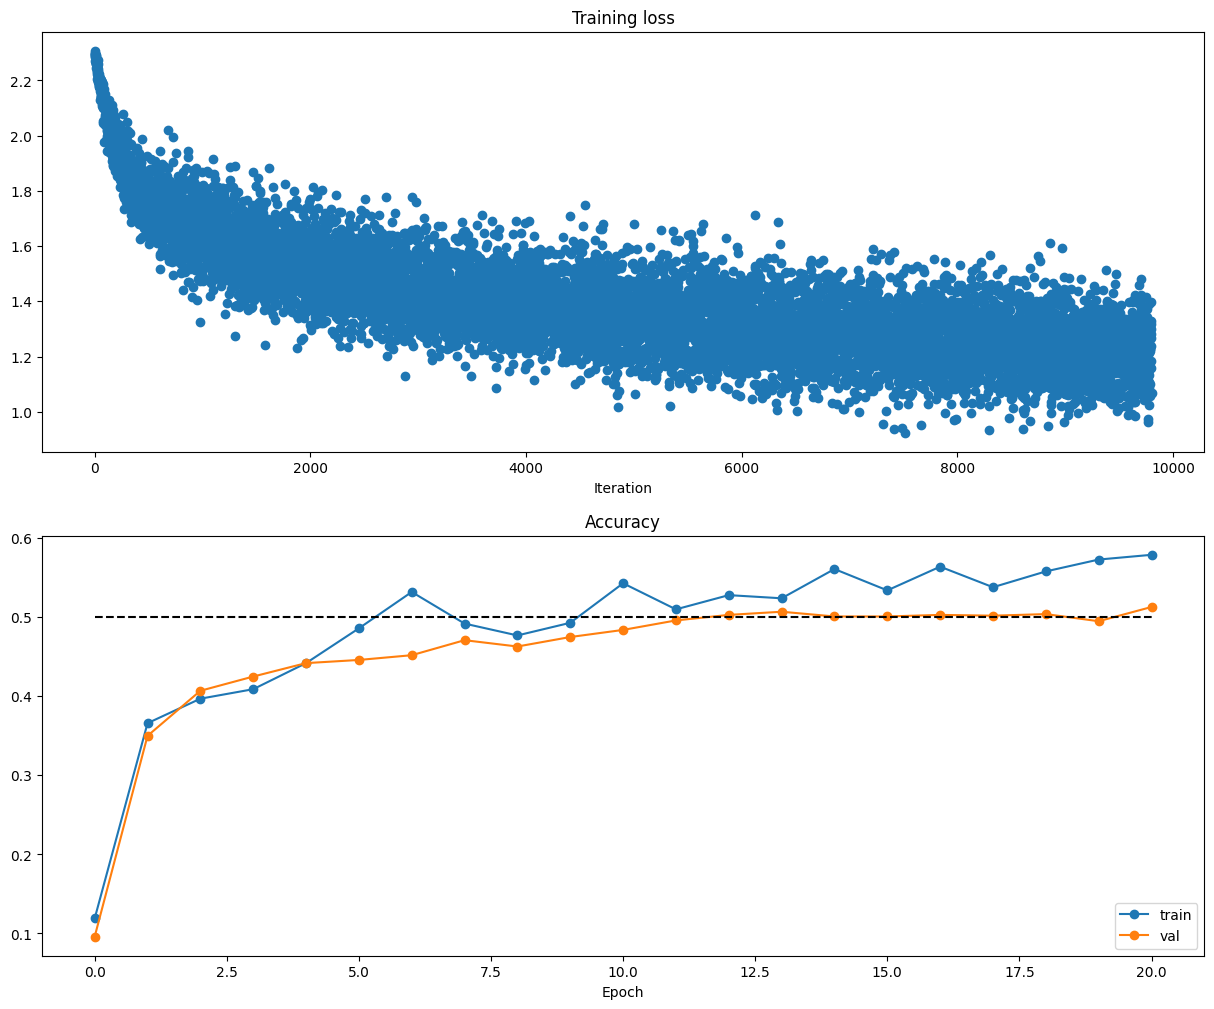

In [30]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(sgd_solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(sgd_solver.train_acc_history, '-o', label='train')
plt.plot(sgd_solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(sgd_solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Tensorflow Implementation

In the following section we will build multiple layer preceptron with tensorflow.

In [31]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
print(tf.__version__)

2.16.1


In [56]:
# Parameters 
learning_rate = 1e-3
training_epochs = 10
batch_size = 100
display_step = 1
# 3072
input_dim = 32*32*3
num_classes = 10

# input placeholder
x = tf.placeholder(tf.float32, [None, input_dim])
y = tf.placeholder(tf.float32, [None, num_classes])

# hidden_dims is a list, the element of the list represents the number of hidden unit for that layer
def tf_nn(input_dim, hidden_dims, num_classes, activation = "relu"):
    
    previous_layer_dim = input_dim
    previous_layer_output = x
    
    for hidden_layer in hidden_dims:
        
        h = tf.Variable(tf.random_normal([previous_layer_dim, hidden_layer]), dtype=tf.float32)
        bias = tf.Variable(tf.random_normal([hidden_layer]), dtype=tf.float32) # tf.Variable(tf.random_normal([hidden_layer, 1]), dtype=tf.float32)
        
        previous_layer_dim = hidden_layer
        if activation == 'relu':
            layer_output = tf.nn.relu(tf.add(tf.matmul(previous_layer_output, h), bias)) 
        else:
            layer_output = tf.nn.sigmoid(tf.add(tf.matmul(previous_layer_output, h), bias))
        previous_layer_output = layer_output
    
    output = tf.Variable(tf.random_normal([previous_layer_dim, num_classes]))
    bias_output = tf.Variable(tf.random_normal([num_classes]))
    output_layer = tf.matmul(layer_output, output) + bias_output
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = output_layer, labels = y))
    
    correct_pred = tf.equal(tf.argmax(output_layer, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    return cost, accuracy

In [57]:
data['X_val'].shape
# y_validation.shape


(1000, 3072)

In [58]:
cost, accuracy = tf_nn(input_dim, [100,100], num_classes, activation = "sigmoid")
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost) 
# Plot settings 
avg_set = [] 
epoch_set = [] 

# Initializing the variables 
init = tf.global_variables_initializer() 
data_dict = get_CIFAR10_data()

data = {
    'X_train': data_dict['X_train'],
    'y_train': data_dict['y_train'],
    'X_val': data_dict['X_val'],
    'y_val': data_dict['y_val'],
}

data['X_train'] = np.reshape(data['X_train'], [data['X_train'].shape[0], 3*32*32])
data['y_train'] = data['y_train'].astype('int') 
batch_ys_final= np.zeros([data['y_train'].shape[0], num_classes])
batch_ys_final[np.arange(data['y_train'].shape[0]), data['y_train']] = 1
data['y_train'] = batch_ys_final

data['X_val'] = np.reshape(data['X_val'], [data['X_val'].shape[0], 3*32*32])
data['y_val'] = data['y_val'].astype('int') 
y_validation= np.zeros([data['y_val'].shape[0], num_classes])
y_validation[np.arange(data['y_val'].shape[0]), data['y_val']] = 1
data['y_val'] = y_validation

# Launch the graph 
with tf.Session() as sess: 
    sess.run(init) 
   
    # Training cycle
    for epoch in range(training_epochs): 
        avg_cost = 0.
        avg_acc = 0.
        total_batch = int(len(data['X_train']) / batch_size) 

        # Loop over all batches 
        for i in range(1, total_batch+1): 
            
            #print("from index %d to index %d " % (batch_size * (i-1), batch_size * i))
            batch_xs = data['X_train'][batch_size * (i-1): batch_size * i]
            batch_ys = data['y_train'][batch_size * (i-1): batch_size * i]
            if i == total_batch:
                batch_xs = data['X_train'][batch_size * (i-1): ]
                batch_ys = data['y_train'][batch_size * (i-1): ]

            # Fit training using batch data 
            sess.run(optimizer, feed_dict = {x: batch_xs, y: batch_ys}) 
            avg_cost += sess.run(cost, feed_dict = {x: batch_xs, y: batch_ys}) / total_batch
            acc = sess.run(accuracy, feed_dict = {x: batch_xs, y: batch_ys})
            # cost_temp = sess.run(cost, feed_dict = {x: batch_xs, y: batch_ys_final}) 
            # Display logs per epoch step 
        if epoch % display_step == 0: 
            print('Epoch : ', (epoch + 1))
            print('avg_cost : ', avg_cost)
            print('training accuracy : ', acc)
            ##############################################################################
            # TODO: here we evaluate the training accuracy, you need you evaluate the    #
            # validation accuracy as well and save it in a variable named val_acc        #
            ##############################################################################
            
            ##############################################################################
            # End your code here                                                         #
            print("Shape of X_val:", data['X_val'].shape)
            print("Shape of y_validation:", y_validation.shape)
            val_acc = sess.run(accuracy, feed_dict = {x: data['X_val'], y: y_validation})
            ##############################################################################
            print('validation accuracy : ', val_acc)
        avg_set.append(avg_cost) 
        epoch_set.append(epoch + 1)
print ("Training phase finished" )

Epoch :  1
avg_cost :  4.683530318493748
training accuracy :  0.18
Shape of X_val: (1000, 3072)
Shape of y_validation: (1000, 10)
validation accuracy :  0.185
Epoch :  2
avg_cost :  2.7810092128053
training accuracy :  0.15
Shape of X_val: (1000, 3072)
Shape of y_validation: (1000, 10)
validation accuracy :  0.213
Epoch :  3
avg_cost :  2.385022405702236
training accuracy :  0.24
Shape of X_val: (1000, 3072)
Shape of y_validation: (1000, 10)
validation accuracy :  0.234
Epoch :  4
avg_cost :  2.2133130175726747
training accuracy :  0.24
Shape of X_val: (1000, 3072)
Shape of y_validation: (1000, 10)
validation accuracy :  0.229
Epoch :  5
avg_cost :  2.1178806390081144
training accuracy :  0.23
Shape of X_val: (1000, 3072)
Shape of y_validation: (1000, 10)
validation accuracy :  0.257
Epoch :  6
avg_cost :  2.0537863101278035
training accuracy :  0.23
Shape of X_val: (1000, 3072)
Shape of y_validation: (1000, 10)
validation accuracy :  0.272
Epoch :  7
avg_cost :  2.0083310667349377
tra

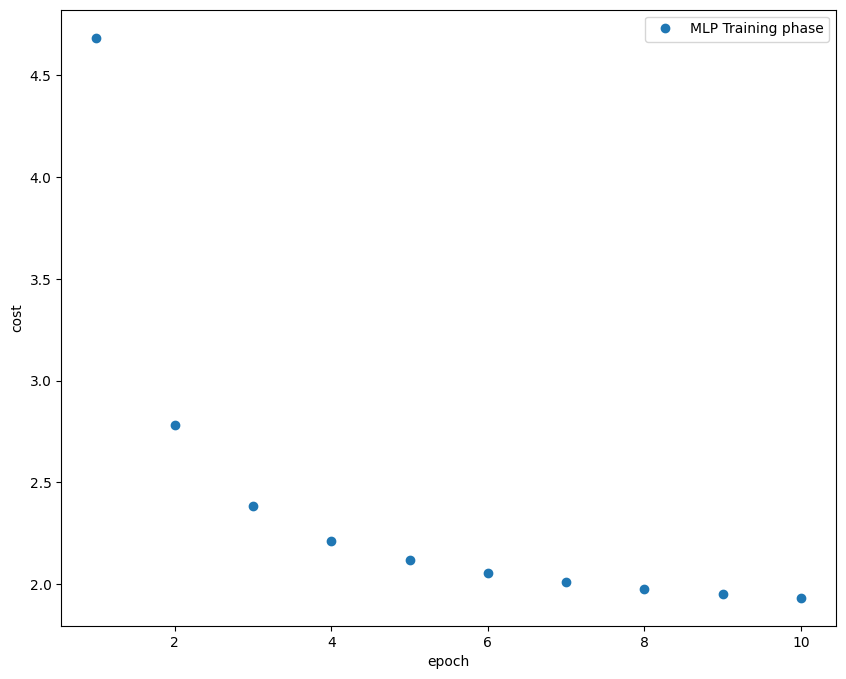

In [59]:
plt.plot(epoch_set, avg_set, 'o', label = 'MLP Training phase') 
plt.ylabel('cost') 
plt.xlabel('epoch') 
plt.legend() 
plt.show()

# Keras Implementation

Here is an example to use keras to build a fully connected network, you can see the code is more concise and more abstract. 
#### For the below code to work you have to restart the kernel and load the cifar dataset once again (i.e First 5 cells of this notebook)


In [3]:
import tensorflow as tf
import keras
# import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Activation, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import SGD


In [4]:
# Multilayer Perceptron (MLP) for multi-class softmax classification:
# ===================================================================

model = Sequential()

model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dense(100, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

opt = keras.optimizers.Adam(0.0001)

model.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       307,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318,410 (1.21 MB)

 Trainable params: 318,410 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
data_dict = get_CIFAR10_data()
num_classes, num_inputs = 10, 50

data = {
    'X_train': data_dict['X_train'],
    'y_train': data_dict['y_train'],
    'X_val': data_dict['X_val'],
    'y_val': data_dict['y_val'],
}

data['X_train'] = np.reshape(data['X_train'], [data['X_train'].shape[0], 32, 32, 3])
data['y_train'] = data['y_train'].astype('int') 
batch_ys_final= np.zeros([data['y_train'].shape[0], num_classes])
batch_ys_final[np.arange(data['y_train'].shape[0]), data['y_train']] = 1
data['y_train'] = batch_ys_final

data['X_val'] = np.reshape(data['X_val'], [data['X_val'].shape[0], 32, 32, 3])
data['y_val'] = data['y_val'].astype('int') 
y_validation= np.zeros([data['y_val'].shape[0], num_classes])
y_validation[np.arange(data['y_val'].shape[0]), data['y_val']] = 1
data['y_val'] = y_validation


hist1 = model.fit(data['X_train'], data['y_train'],
                   epochs=10,
                   batch_size=32,
                   validation_data=(data['X_val'], data['y_val']))
# unexpectd keyword argument "lr"

Epoch 1/10
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2199 - loss: 2.1830 - val_accuracy: 0.3270 - val_loss: 1.9631
Epoch 2/10
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3097 - loss: 1.9471 - val_accuracy: 0.3450 - val_loss: 1.8932
Epoch 3/10
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3313 - loss: 1.8969 - val_accuracy: 0.3510 - val_loss: 1.8651
Epoch 4/10
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3359 - loss: 1.8764 - val_accuracy: 0.3680 - val_loss: 1.8409
Epoch 5/10
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3468 - loss: 1.8424 - val_accuracy: 0.3730 - val_loss: 1.8310
Epoch 6/10
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3498 - loss: 1.8336 - val_accuracy: 0.3660 - val_loss: 1.8198
Epoch 7/10
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3527 - loss: 1.8279 - val_accuracy: 0.3640 - val_loss: 1.8098
Epoch 8/10
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3554 - loss: 1.8226 - 

# Training A Three-Layer Neural Network on MNIST Dataset

You've seen how to train and evaluate your neural network model on CIFAR10 dataset, it's your turn to train a three-layer Neural Network on MINIST Dataset.  Implement the model with Tensorflow or Keras. Tune the parameters to find the best hyperparameters for your model. 

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import random

from keras.datasets import mnist
from keras.models import Sequential

from keras.layers import Dense, Dropout, Activation
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [19]:
print(tf.__version__)

2.16.1


In [44]:
# load out data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


In [45]:
# reshape data, flatten out to a 784 vector
X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors
X_test = X_test.reshape(10000, 784) # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors

X_train = X_train.astype('float32') # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255 # normalize each value for each pizel for the entire vector for each input
X_test /=255

print('training matrix shape', X_train.shape)
print('testing matrix shape', X_test.shape)

training matrix shape (60000, 784)
testing matrix shape (10000, 784)


In [46]:
# review and set up y values
nb_classes = 10 # number of unique digits

Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

print('training matrix shape', Y_train.shape)
print('testing matrix shape', Y_test.shape)

training matrix shape (60000, 10)
testing matrix shape (10000, 10)


In [47]:
def neural_net_model(learning_rate=0.01, dropout_rate=0.2, activation='relu', n_units=512):
    # model (sequential model)
    model = Sequential()

    # input
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation(activation))
    model.add(Dropout(0.2))

    # hidden Layer 1
    model.add(Dense(512))
    model.add(Activation(activation))
    model.add(Dropout(0.2))

    # hidden Layer 2
    model.add(Dense(512))  # Another layer with 512 neurons
    model.add(Activation(activation))
    model.add(Dropout(0.2))

    # output
    model.add(Dense(10))  # Assuming 10 classes for classification
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [38]:
# hyper parameter tuning
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2)

learning_rates = [0.001, 0.01, 0.1]
n_units_options = [256, 512]
dropout_rates = [0.2, 0.5]
activation = ['relu', 'tanh']

best_accuracy = 0
best_params = {}

for lr in learning_rates:
    for units in n_units_options:
        for dr in dropout_rates:
            for act in activation:
                model = neural_net_model(learning_rate=lr, n_units=units, dropout_rate=dr, activation=act)
                model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0)
                score = model.evaluate(x_val, y_val, verbose=0)
                print(f'Tested {lr}, {units}, {dr}, {act}: Validation accuracy = {score[1]}')

                if score[1] > best_accuracy:
                    best_accuracy = score[1]
                    best_params = {'learning_rate': lr, 'n_units': units, 'dropout_rate': dr, 'activation': act}

print(f"Best params: {best_params} with accuracy {best_accuracy}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Tested 0.001, 256, 0.2, relu: Validation accuracy = 0.9724934697151184
Tested 0.001, 256, 0.2, tanh: Validation accuracy = 0.9697265625
Tested 0.001, 256, 0.5, relu: Validation accuracy = 0.9763997197151184
Tested 0.001, 256, 0.5, tanh: Validation accuracy = 0.9581705927848816
Tested 0.001, 512, 0.2, relu: Validation accuracy = 0.9718424677848816
Tested 0.001, 512, 0.2, tanh: Validation accuracy = 0.9656575322151184
Tested 0.001, 512, 0.5, relu: Validation accuracy = 0.9739583134651184
Tested 0.001, 512, 0.5, tanh: Validation accuracy = 0.96484375
Tested 0.01, 256, 0.2, relu: Validation accuracy = 0.9708659052848816
Tested 0.01, 256, 0.2, tanh: Validation accuracy = 0.9656575322151184
Tested 0.01, 256, 0.5, relu: Validation accuracy = 0.974609375
Tested 0.01, 256, 0.5, tanh: Validation accuracy = 0.9658203125
Tested 0.01, 512, 0.2, relu: Validation accuracy = 0.9742838740348816
Tested 0.01, 512, 0.2, tanh: Validation accuracy = 0.9646809697151184
Tested 0.01, 512, 0.5, relu: Validation

In [49]:
Y_train.shape

(60000, 10)

In [50]:

model = neural_net_model(
    learning_rate=best_params['learning_rate'], 
    n_units=best_params['n_units'], 
    dropout_rate=best_params['dropout_rate'], 
    activation='relu'
)

# fit data
model.fit(
    X_train,
    Y_train,
    batch_size=128,
    epochs=5,
    verbose=1
)

# get model score
score = model.evaluate(X_test, Y_test)
print('test score:', score[0])
print('test accuracy:', score[1])

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8551 - loss: 0.4680
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9660 - loss: 0.1097
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9746 - loss: 0.0807
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9802 - loss: 0.0628
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9836 - loss: 0.0506
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.9759 - loss: 0.0821
test score: 0.07017846405506134
test accuracy: 0.9800999760627747


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


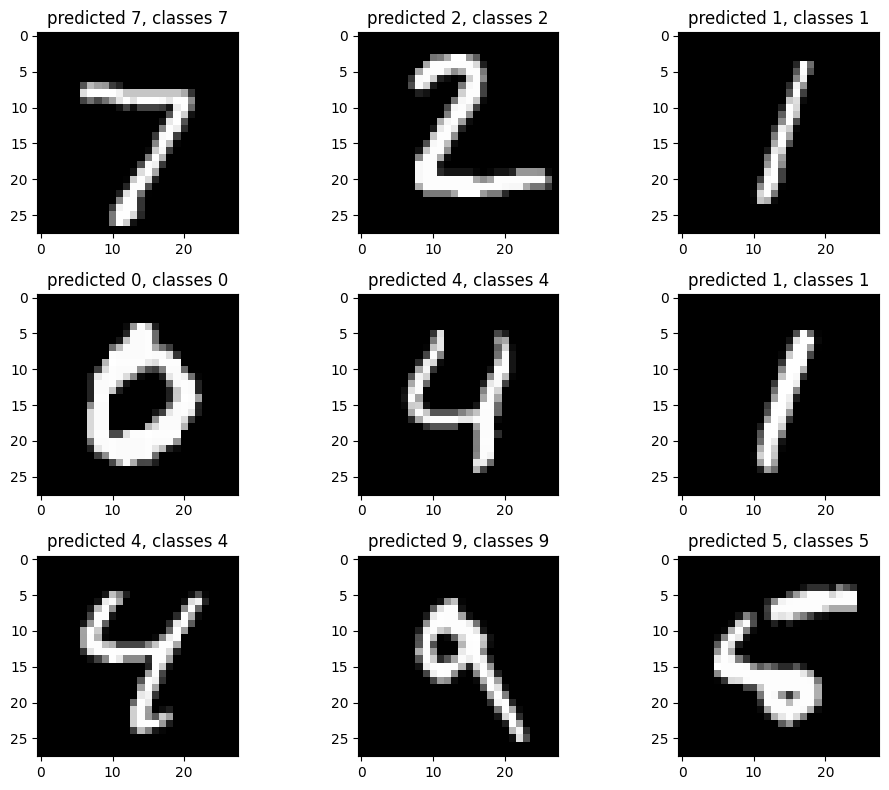

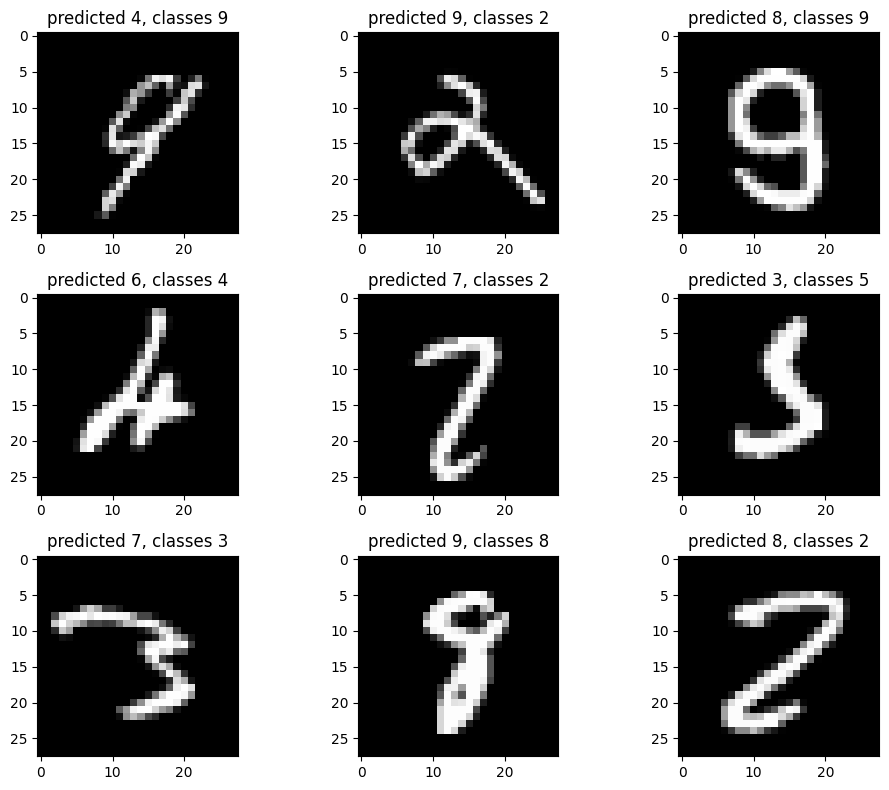

In [51]:
# checking results
predicted_probs = model.predict(X_test)
predicted_classes = predicted_classes = np.argmax(predicted_probs, axis=1)
y_test_labels = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

# plot results
%matplotlib inline
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[correct].reshape(28, 28), cmap='gray', interpolation='none')
    plt.title('predicted {}, classes {}'.format(predicted_classes[correct], y_test[correct]))

plt.tight_layout()
plt.show()

plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3,i+1)
    plt.imshow(X_test[incorrect].reshape(28, 28), cmap='gray', interpolation='none')
    plt.title('predicted {}, classes {}'.format(predicted_classes[incorrect], y_test[incorrect]))

plt.tight_layout()
plt.show()

# Question:  What did you discover with hyperparameter tuning?


I was surprised to see that the learning rate of 0.1 yielded a greater accuracy. However, it may be that this larger learning rate is causing the model to overfit. The other parameters for number of units, drop out rate, and activation seemed to yield greater accuracy overall when compared to each of the other hyperparameter choices. 